# Homework Assignment # 13 (Week 13)
### Authored by: Shweta Narkhede
### Submitted on: Nov 23rd, 2020

___

## Table of contents:
1. [Description](#descrip)
2. [Map of study location](#maps)
3. [Python Codes](#pcodes)
    1. [Importing modules/packages](#imp)
    2. [Creating map of study location](#map)
    3. [Data Collection](#data)
    4. [Auto-regressive Model](#model)
    5. [Data and forecast visualization](#graphs)
4. [Forecasted flows](#results)

<a name="descrip"></a>
## 1. Description

This is a detailed report of 16 weeks streamflow forecasts at a Verde river streamguage station in Arizona. The report consists of map of the study area, datasets used for predicting streamflow, Auto-regressive model developed for predicting streamflows and output visualization in the form of graphs and histograms. The details of each component will be described in subsequent sections. The relevent python codes are included in the corresponding sections. 

<a name="maps"></a>
## 2. Map of study location

The map shows location of Verde River stream gauge station in lower Colorado basin in Arizona state. The data required to create map is too large to upload, so the data is saved locally and map is generated. Here, the python script to generate map is shared in the section named python codes below and the map is added to this report in the form of image file.

The data required for generating map was downloaded from USGS and sciencebase website. The link to data are given below:

1. [ Streamgauges: Gauges II USGS stream gauge dataset ](https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder)
 
2. [ Watershed: Boundaries for Lower Colorado basin ](https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products)
 
3. [ Arizona state boundaries](https://www.sciencebase.gov/catalog/item/59fa9f59e4b0531197affb13)

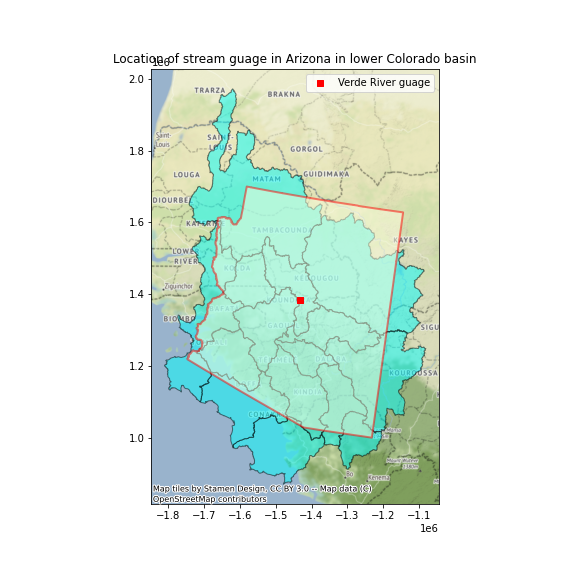

<a name="pcodes"></a>
## 3. Python Codes
1. [Importing modules/packages](#imp)
2. [Creating map of study location](#map)
3. [Data Collection](#data)
4. [Auto-regressive Model](#model)
5. [Data and forecast visualization](#graphs)

<a name="imp"></a>
## 1. Importing modules/packages

 Importing the required modules/packages necessary to run the python script. 


In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import json
import urllib.request as req
import urllib
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx
import seaborn as sns
import model_function as mf # AR model as a function from another script
import plot_function as pf # plotting functions from another script


from shapely.geometry import Point
import contextily as ctx

<a name="map"></a>
## 2. Creating map of study location

Following code was used to generate map outside this jupyter notebook and was saved in image format to add to the above section of [Map of study location](#maps)


NOTE: Following python script won't run as data cannot be uploaded to the the current repo due its huge size.

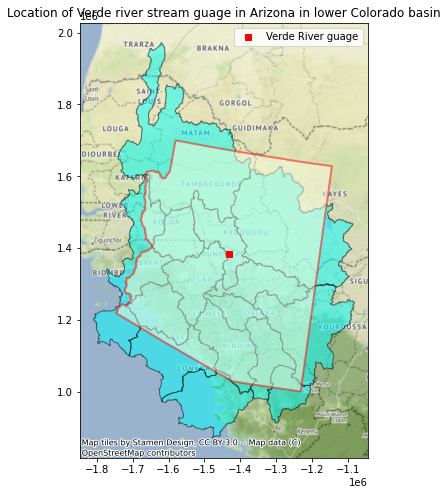

In [31]:
# Don't run this cell

# Python code for generating map of study location


#  1. Streamgauges: Gauges II USGS stream gauge dataset

# Reading it using geopandas
file = os.path.join('/Users/owner/Documents/GitHub/Python Mapping/data/gagesII_9322_point_shapefile',
                    'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# Seperating guages from Arizona
gages_AZ = gages[gages['STATE'] == 'AZ']
gages_AZ.shape

# 2. Watershed: Boundaries for Lower Colorado basin

# Watershed boundaries for the lower colorado
file = os.path.join('/Users/owner/Documents/GitHub/Python Mapping/data/WBD_15_HU2_GDB', 'WBD_15_HU2_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

# Adding Verde River Stream gauge
verde_gage = gages_AZ[gages_AZ['STAID'] ==
                      '09506000'][['LAT_GAGE', 'LNG_GAGE']]
point_list = np.array([[-111.789871, 34.448361]])

# make these into spatial features
point_geom = [Point(xy) for xy in point_list]

# mape a dataframe of these points
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=HUC6.crs)

# 3. Arizona state boundaries

filepath2 = os.path.join('/Users/owner/Documents/GitHub/Python Mapping/data/State_bnd', 'GU_StateOrTerritory.shp')
fiona.listlayers(filepath2)
state = gpd.read_file(filepath2)

state_AZ = state[state['State_Name'] == 'Arizona'][['geometry']]
state_df = gpd.GeoDataFrame(state_AZ, columns=['geometry'],
                            crs=HUC6.crs)

# Re-projecting Verde gage
points_project = point_df.to_crs(gages_AZ.crs)
HUC6_project = HUC6.to_crs(gages_AZ.crs)
State_bnd = state_df.to_crs(gages_AZ.crs)

# Plotting final all in one
fig, ax = plt.subplots(figsize=(8, 8))
HUC6_project.plot(ax=ax, edgecolor='black', alpha=0.5,
                  facecolor='cyan', legend=True)
State_bnd.plot(ax=ax, color='lightyellow', alpha=0.5, edgecolor='r', linewidth=2)
points_project.plot(ax=ax, color='r', marker='s', markersize=45)
ctx.add_basemap(ax)
ax.set_title("Location of Verde river stream guage in Arizona in lower Colorado basin")
ax.legend(['Verde River guage'])
plt.show()
fig.savefig("Map.png")

# %%


<a name="data"></a>
## 3. Data Collection

Collecting data from USGS webiste using URL and API format and converting it to useful dataframe format of weekly flows

In [32]:
# Providing specific arguments for collecting required data

site = '09506000'
start = "1989-01-01"
end = "2020-11-21"

url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" \
      + site + "&referred_module=sw&period=&begin_date=" + start + \
      "&end_date=" + end
# $ Only works if you select tab seperated data
flowdata = pd.read_table(url, sep='\t', skiprows=30,
                         names=['agency_cd', 'site_no',
                                'datetime', 'flow', 'code'],
                         parse_dates=['datetime'])

# Expanding the dates to year, month, day and day of week
flowdata['year'] = pd.DatetimeIndex(flowdata['datetime']).year
flowdata['month'] = pd.DatetimeIndex(flowdata['datetime']).month
flowdata['day'] = pd.DatetimeIndex(flowdata['datetime']).day
flowdata['dayofweek'] = pd.DatetimeIndex(flowdata['datetime']).dayofweek

# Aggregating flow values to weekly (weekly averaged flow)
flow_weekly = flowdata.resample("W", on='datetime').mean()

<a name="model"></a>
## 3. Developing Auto-regressive Model

Auto-regressive model is developed using 8 lagged timesteps inputs of streamflows. The number of lagged inputs were decided based on the highest coefficient of determination of model using different number of inputs. With multiple trials, it was decided to use eight lagged inputs for highest COD of the AR model.

Considering additiional data sets of other variables like air temperature and precipitataion seemed not to affect this AR model much, so it was decided to drop those datasets and continue using single variable as a input to AR model.

For the current model, only August to Novemnber of 2020 streamflow records are chosen as a input to the AR model as trend is different this year compared to past records.

The model is set to forecast next week streamflow and using forecasted data to make further predictions as required. For this assignment, 16 weeks predictions are required, so model is set to predict (16 - current week (i.e. 13th) = 3 next predictions) for week 14th, 15th and 16th. Sinec teh data for past 13 weeks is known to us, the weekly averaged streamflow for each week 1st to last week (i.e. 12th week) is directly used.


In [33]:
# Creating input dataframe to use for AR model

Comb_data = flow_weekly
for i in range(1, 9):
    flow_weekly['tm' '%s' % (i)] = flow_weekly['flow'].shift(i)

lag_cols = ['flow', 'tm1', 'tm2', 'tm3', 'tm4', 'tm5', 'tm6', 'tm7', 'tm8']

# Selecting data to use for prediction
mydata = Comb_data[(Comb_data['year'] >= 2020) &
                   (Comb_data['month'] <= 11) &
                   (Comb_data['month'] >= 8)][lag_cols]


In [34]:
# Using AR_model function to predict streamflows for 16 weeks

# Creating empty dataframe for storing predicted flows
predicted_flows = pd.DataFrame(columns=["Week", "Flow"])
current_week = 13

# For loop for making predictions for 16 weeks
for i in range(current_week, 16):

    x1 = mydata[lag_cols[1:10]].values
    y1 = mydata[['flow']].values
    last_week_flow = mydata.tail(1)[lag_cols[1:10]]
    nextweek_pred = mf.AR_Model(x1, y1, last_week_flow).round(2)

    mydata = mydata.append({'flow': nextweek_pred,
                            'tm1': mydata.flow[(mydata.flow.size-1)],
                            'tm2': mydata.flow[(mydata.flow.size-2)],
                            'tm3': mydata.flow[(mydata.flow.size-3)],
                            'tm4': mydata.flow[(mydata.flow.size-4)],
                            'tm5': mydata.flow[(mydata.flow.size-5)],
                            'tm6': mydata.flow[(mydata.flow.size-6)],
                            'tm7': mydata.flow[(mydata.flow.size-7)],
                            'tm8': mydata.flow[(mydata.flow.size-8)]
                            }, ignore_index=True)

    predicted_flows = predicted_flows.append(
        {'Week': [i+1], 'Flow': nextweek_pred[0][0]}, ignore_index=True)

print(predicted_flows)

# Forecast entries for previous weeks (Week 1 to 10)
previous_weeks_entries = pd.Series(flow_weekly.flow.tail(current_week).values)

# Total 16 weeks entries to be submitted for forecast competition
Forecast_entries = pd.DataFrame(columns=["Week", "Flow"])
aggregate = previous_weeks_entries.append(predicted_flows.Flow)
Forecast_entries['Flow'] = aggregate.T
Forecast_entries['Week'] = range(1, 17)
Forecast_entries = Forecast_entries.set_index('Week')
print(Forecast_entries)
print('Week 1 forecast = ', Forecast_entries.Flow[current_week+1],
      ' and Week 2 Forecast = ', Forecast_entries.Flow[current_week+2])


   Week    Flow
0  [14]  177.98
1  [15]  181.76
2  [16]  199.37
            Flow
Week            
1      54.085714
2      56.828571
3      44.357143
4      57.971429
5      62.000000
6      60.085714
7      67.771429
8      73.314286
9      83.128571
10    113.700000
11    128.142857
12    158.142857
13    155.833333
14    177.980000
15    181.760000
16    199.370000
Week 1 forecast =  177.98  and Week 2 Forecast =  181.76


<a name="graphs"></a>
## 2. Data and forecast visualization


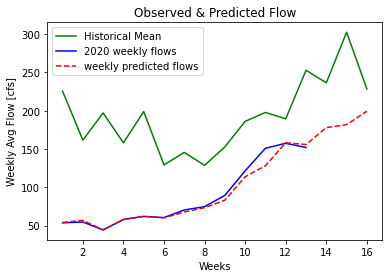

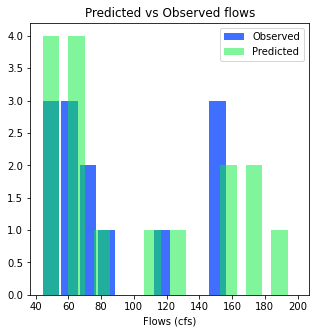

In [35]:
# Plotting historical weekly mean from 1989 to 2019, observed 2020 weekly flows and 2020 weekly predicted flows

hist_flow = pf.hist_daily_mean(flowdata, 2020)

# Calculating the weekly mean & joining in the

Forecast_entries['week_hist'] = pf.weekly_mean(hist_flow, 8, 22, 16)
Forecast_entries['week_2020'] = pf.weekly_mean(flowdata, 8, 22, 12, 2020)
pf.plot_3series(Forecast_entries['week_hist'].T,
                   Forecast_entries['week_2020'].T,
                   Forecast_entries['Flow'].T, 2020)
# Plotting histogram of observed and forecatsed flows for 2020
f, ax = plt.subplots(figsize = (5,5))
plt.hist(Forecast_entries['week_2020'].T, alpha = 0.75,width = 10, label = 'Observed')
plt.hist(Forecast_entries['Flow'].T, alpha = 0.5, width = 10, label = 'Predicted')
plt.xlabel('Flows (cfs)')
plt.title('Predicted vs Observed flows')
plt.legend()


<a name="results"></a>
##  4. Forecasted Flows

Following are the predictions for 16 week streamflows:

In [36]:
print(Forecast_entries.Flow.to_markdown())

print('Week 1 forecast = ', Forecast_entries.Flow[current_week+1],'cfs',
      ' and Week 2 Forecast = ', Forecast_entries.Flow[current_week+2],'cfs')


|   Week |     Flow |
|-------:|---------:|
|      1 |  54.0857 |
|      2 |  56.8286 |
|      3 |  44.3571 |
|      4 |  57.9714 |
|      5 |  62      |
|      6 |  60.0857 |
|      7 |  67.7714 |
|      8 |  73.3143 |
|      9 |  83.1286 |
|     10 | 113.7    |
|     11 | 128.143  |
|     12 | 158.143  |
|     13 | 155.833  |
|     14 | 177.98   |
|     15 | 181.76   |
|     16 | 199.37   |
Week 1 forecast =  177.98 cfs  and Week 2 Forecast =  181.76 cfs
